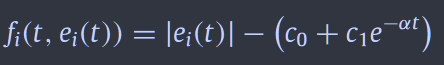

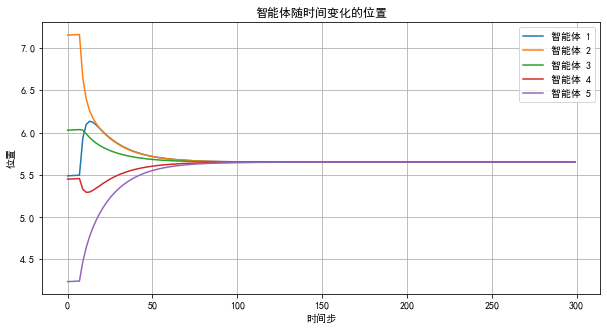

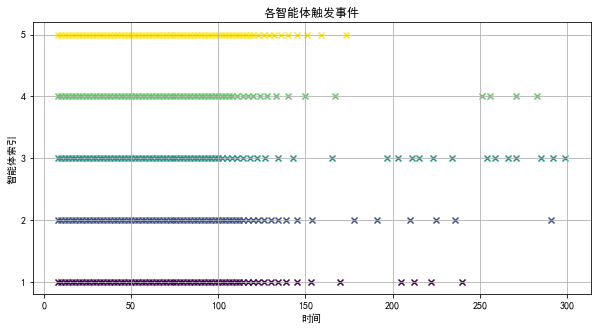

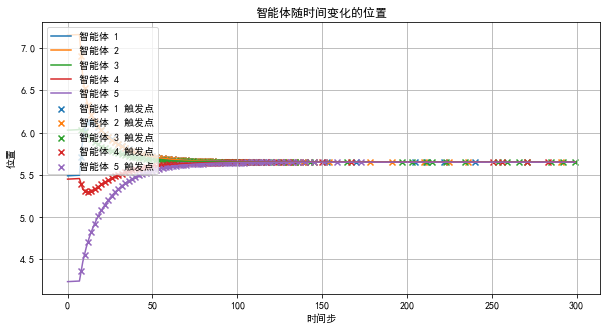

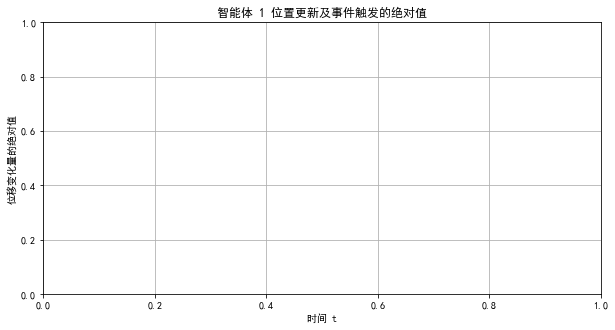

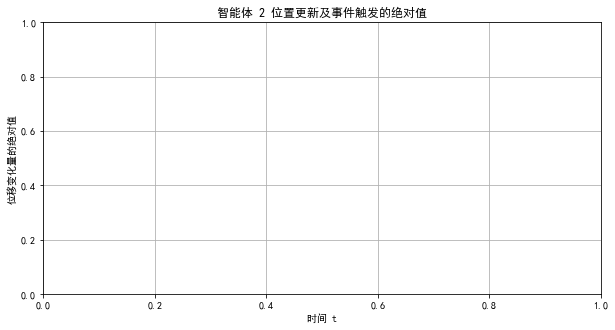

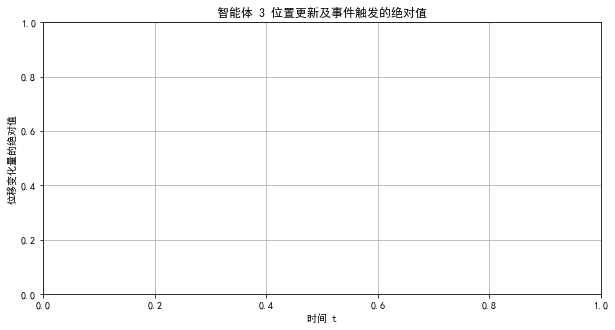

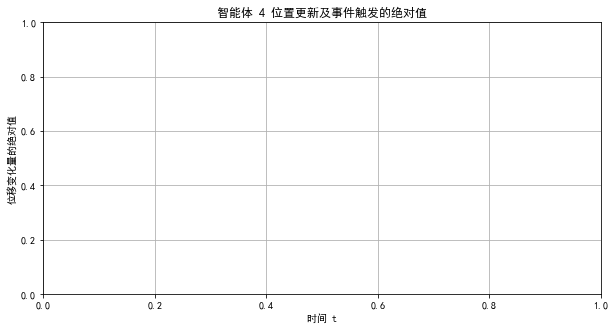

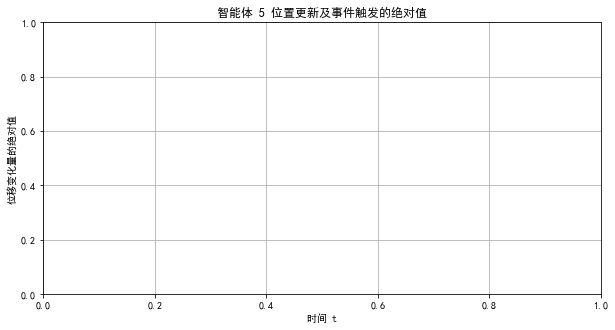

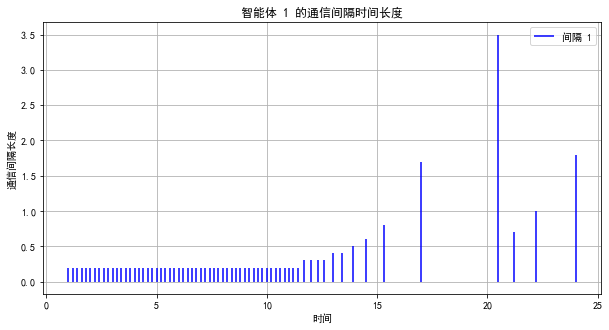

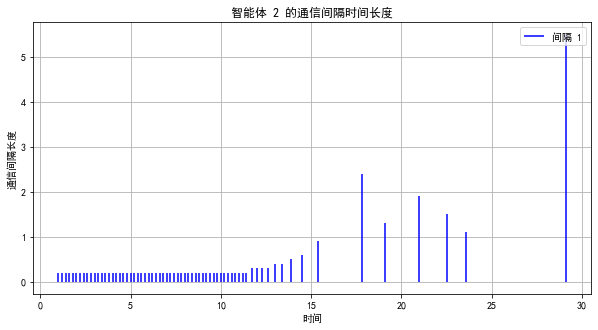

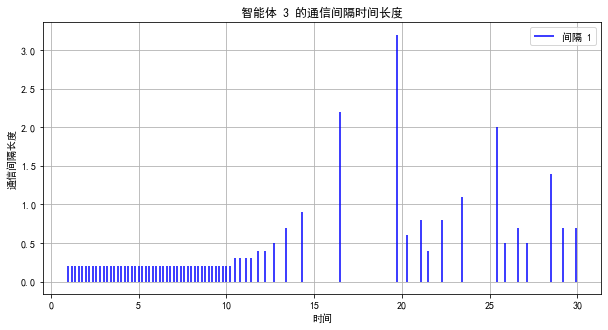

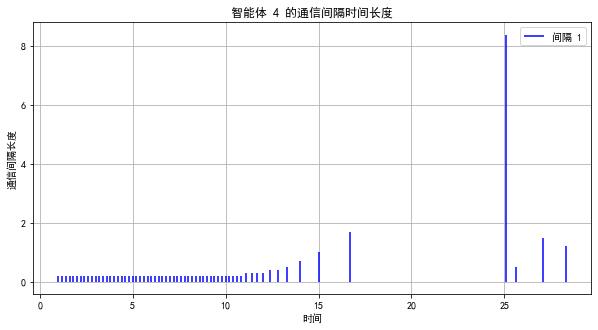

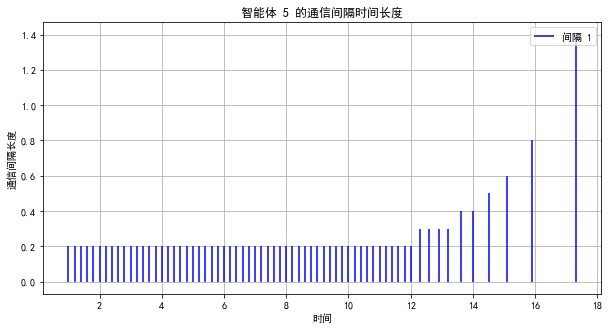

In [98]:
import numpy as np
import matplotlib.pyplot as plt

class Agent:
    def __init__(self, initial_position, index):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.trigger_points = []
        self.trigger_points2 = []  # 用于记录事件触发时的位置
        self.delta_positions = []
        self.communication_times = []  # 记录每次通信的时间
        self.z = 0.01
        self.c_0 = 0.0001
        self.c_1 = 0.2499
        self.alpha = 0.4669
        
        
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def get_position(self):
        return self.position
    
    def update_position(self, t, dt):
        e_i = self.last_broadcast_position - self.position
        z_bar_squared = - sum(self.is_neighbor(neighbor) * (self.position - neighbor.get_position()) for neighbor in self.neighbors)
        trigger_condition = np.abs(e_i) - (self.c_0 + self.c_1 * np.exp(- self.alpha * t))
        
        # 如果事件触发函数大于等于0，则更新位置并广播新位置
        if trigger_condition >= 0:
            self.position += z_bar_squared * dt
            self.last_broadcast_position = self.position
            self.z = z_bar_squared
            #记录触发的相关信息
            self.delta_positions.append(self.last_broadcast_position - self.position)
            self.trigger_points2.append(t * dt)
            self.trigger_points.append((t, self.position))
            self.communication_times.append(t * dt)
            #print("1")
        else:
            self.position += self.z * dt
            #print("nnnnnnnnnnnnnnnnnnnnnnnnnnnnnn")
        '''print(self.z)
        print(z_bar_squared)    
        print()'''        
            

# 初始化参数和智能体
num_agents = 5
num_iterations = 300
dt = 0.1
np.random.seed(0)
agents = [Agent(np.random.rand() * 10, i) for i in range(num_agents)]

# 定义邻居关系
agents[0].add_neighbor(agents[1])
agents[0].add_neighbor(agents[2])
agents[1].add_neighbor(agents[2])
agents[2].add_neighbor(agents[3])
agents[3].add_neighbor(agents[4])

L = np.array([[ 2, -1, -1,  0,  0],
              [-1,  2, -1,  0,  0],
              [-1, -1,  3, -1,  0],
              [ 0,  0, -1,  2, -1],
              [ 0,  0,  0, -1,  1]])

# 计算拉普拉斯矩阵的特征值
eigenvalues = np.linalg.eigvalsh(L)
# 谱范数是所有特征值的绝对值中的最大值
spectral_norm = np.max(np.abs(eigenvalues))
# 第二小的特征值，也被称为网络的代数连通性
second_smallest_eigenvalue = np.partition(eigenvalues, 1)[1]



# 运行模拟
positions = np.zeros((num_iterations, num_agents))
for t in range(num_iterations):
    for agent in agents:
        agent.update_position(t, dt)
        positions[t, agent.index] = agent.position


# 绘制结果图
plt.figure(figsize=(10, 5))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'智能体 {i+1}')
plt.xlabel('时间步')
plt.ylabel('位置')
plt.title('智能体随时间变化的位置')
plt.legend()
plt.grid(True)


# 绘制触发事件图，确保智能体的触发事件颜色与其位置图中的颜色相匹配
plt.figure(figsize=(10, 5))
colors = plt.cm.viridis(np.linspace(0, 1, num_agents))  # 生成颜色映射
# 收集所有智能体的触发时间点和对应的索引
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t, i, marker='x', color=color)  # 使用相应颜色绘制触发事件
plt.xlabel('时间')
plt.ylabel('智能体索引')
plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'智能体 {i+1}')
    # 绘制事件触发点
    if agent.trigger_points:
        trigger_times, trigger_positions = zip(*agent.trigger_points)
        plt.scatter(trigger_times, trigger_positions, marker='x', label=f'智能体 {i + 1} 触发点')
plt.xlabel('时间步')
plt.ylabel('位置')
plt.title('智能体随时间变化的位置')
plt.legend()
plt.grid(True)


for index, agent in enumerate(agents):
    plt.figure(figsize=(10, 5))
    for trigger_time, delta_position in zip(agent.trigger_points, agent.delta_positions):  
        if delta_position != 0:
            absolute_delta = abs(delta_position)
            plt.vlines(trigger_time, 0, absolute_delta, colors='r')
            plt.plot(trigger_time[0], 0, 'bo')  
    plt.xlabel('时间 t')
    plt.ylabel('位移变化量的绝对值')
    plt.title(f'智能体 {index + 1} 位置更新及事件触发的绝对值')
    plt.grid(True)


for index, agent in enumerate(agents):
    if len(agent.communication_times) > 1:
        # 计算相邻两次通信的时间间隔
        intervals = np.diff(agent.communication_times)
        plt.figure(figsize=(10, 5))  # 为每个智能体创建一个新的图形
        for i, time in enumerate(agent.communication_times[1:]):
            # 在每次通信时间点上绘制一条垂直线，长度代表时间间隔
            plt.vlines(time, 0, intervals[i], label=f'间隔 {i+1}' if i == 0 else "", color='b')  # 仅在第一条线添加图例标签
        plt.xlabel('时间')
        plt.ylabel('通信间隔长度')
        plt.title(f'智能体 {index + 1} 的通信间隔时间长度')
        plt.legend()
        plt.grid(True)
        plt.show()

    # 解决中文显示问题
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号 '-' 显示为方块的问题

plt.show()

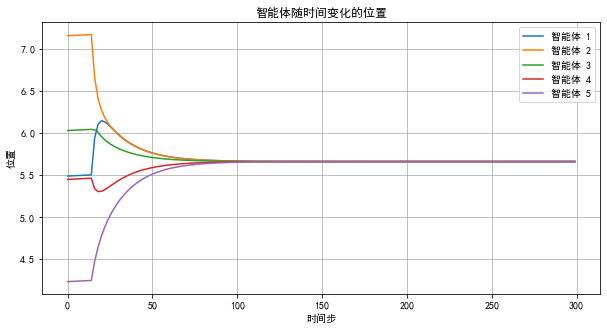

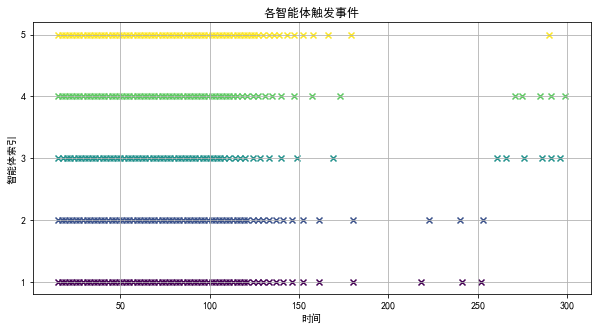

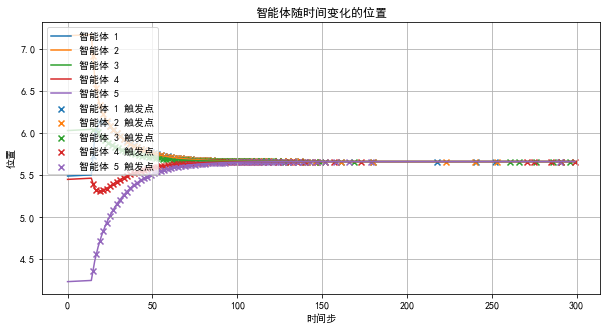

In [97]:
import numpy as np
import matplotlib.pyplot as plt

class Agent:
    def __init__(self, initial_position, index):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.trigger_points = []
        self.z = 0.01
        self.c_0 = 0.0001
        self.c_1 = 0.2499
        self.alpha = 0.9 * second_smallest_eigenvalue
        
        
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def get_position(self):
        return self.position
    
    def update_position(self, t, dt):
        e_i = self.last_broadcast_position - self.position
        trigger_condition = np.abs(e_i) - (self.c_0 + self.c_1 * np.exp(- self.alpha * t))
        
        # 如果事件触发函数大于等于0，则更新位置并广播新位置
        if trigger_condition >= 0:
            z_bar_squared = - sum(self.is_neighbor(neighbor) * (self.position - neighbor.get_position()) for neighbor in self.neighbors)
            self.position += z_bar_squared * dt
            self.last_broadcast_position = self.position
            self.z = z_bar_squared
            #记录触发的相关信息
            self.trigger_points.append((t, self.position))
        else:
            self.position += self.z * dt      
            

# 初始化参数和智能体
num_agents = 5
num_iterations = 300
dt = 0.1
np.random.seed(0)
agents = [Agent(np.random.rand() * 10, i) for i in range(num_agents)]

# 定义邻居关系
agents[0].add_neighbor(agents[1])
agents[0].add_neighbor(agents[2])
agents[1].add_neighbor(agents[2])
agents[2].add_neighbor(agents[3])
agents[3].add_neighbor(agents[4])

L = np.array([[ 2, -1, -1,  0,  0],
              [-1,  2, -1,  0,  0],
              [-1, -1,  3, -1,  0],
              [ 0,  0, -1,  2, -1],
              [ 0,  0,  0, -1,  1]])

# 计算拉普拉斯矩阵的特征值
eigenvalues = np.linalg.eigvalsh(L)
# 谱范数是所有特征值的绝对值中的最大值
spectral_norm = np.max(np.abs(eigenvalues))
# 第二小的特征值，也被称为网络的代数连通性
second_smallest_eigenvalue = np.partition(eigenvalues, 1)[1]



# 运行模拟
positions = np.zeros((num_iterations, num_agents))
for t in range(num_iterations):
    for agent in agents:
        agent.update_position(t, dt)
        positions[t, agent.index] = agent.position


# 绘制结果图
plt.figure(figsize=(10, 5))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'智能体 {i+1}')
plt.xlabel('时间步')
plt.ylabel('位置')
plt.title('智能体随时间变化的位置')
plt.legend()
plt.grid(True)


# 绘制触发事件图，确保智能体的触发事件颜色与其位置图中的颜色相匹配
plt.figure(figsize=(10, 5))
colors = plt.cm.viridis(np.linspace(0, 1, num_agents))  # 生成颜色映射
# 收集所有智能体的触发时间点和对应的索引
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t, i, marker='x', color=color)  # 使用相应颜色绘制触发事件
plt.xlabel('时间')
plt.ylabel('智能体索引')
plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'智能体 {i+1}')
    # 绘制事件触发点
    if agent.trigger_points:
        trigger_times, trigger_positions = zip(*agent.trigger_points)
        plt.scatter(trigger_times, trigger_positions, marker='x', label=f'智能体 {i + 1} 触发点')
plt.xlabel('时间步')
plt.ylabel('位置')
plt.title('智能体随时间变化的位置')
plt.legend()
plt.grid(True)


# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号 '-' 显示为方块的问题

plt.show()